# Monte-Carlo control 

We start by importing gym. The environment we will use is text-based, so there is no need for all the boilerplate of last exercise: we simply pip install gym if we are on Colab.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
rng = np.random.default_rng()
import time

from IPython.display import clear_output

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !pip install gym > /dev/null 2>&1
    
import gym

## The taxi environment

In this exercise, we are going to apply **on-policy Monte-Carlo control** on the Taxi environment available in gym:

<https://gym.openai.com/envs/Taxi-v3/>

In [2]:
import gym.envs.toy_text.taxi
help(gym.envs.toy_text.taxi)

Help on module gym.envs.toy_text.taxi in gym.envs.toy_text:

NAME
    gym.envs.toy_text.taxi

CLASSES
    gym.envs.toy_text.discrete.DiscreteEnv(gym.core.Env)
        TaxiEnv
    
    class TaxiEnv(gym.envs.toy_text.discrete.DiscreteEnv)
     |  The Taxi Problem
     |  from "Hierarchical Reinforcement Learning with the MAXQ Value Function Decomposition"
     |  by Tom Dietterich
     |  
     |  Description:
     |  There are four designated locations in the grid world indicated by R(ed), G(reen), Y(ellow), and B(lue). When the episode starts, the taxi starts off at a random square and the passenger is at a random location. The taxi drives to the passenger's location, picks up the passenger, drives to the passenger's destination (another one of the four specified locations), and then drops off the passenger. Once the passenger is dropped off, the episode ends.
     |  
     |  Observations: 
     |  There are 500 discrete states since there are 25 taxi positions, 5 possible locations 

Let's create the environment, initialize it  and render the first state:

In [3]:
env = gym.make("Taxi-v3")
state = env.reset()
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



The agent is the yellow square. It can move up, down, left or right if there is no wall (the pipes and dashes). Its goal is to pick clients at the blue location and drop them off at the pink location. These locations are fixed (R, G, B, Y), but which one is the pick-up location and which one is the drop-off destination changes between each episode.

**Q:** Re-run the previous cell multiple times to observe the diversity of initial states.

The following cell prints the action space of the environment: 

In [4]:
print("Action Space", env.action_space)
print("Number of actions", env.action_space.n)

Action Space Discrete(6)
Number of actions 6


There are 6 discrete actions: south, north, east, west, pickup, dropoff.
    
Let's now look at the observation space (state space):

In [5]:
print("State Space", env.observation_space)
print("Number of states", env.observation_space.n)

State Space Discrete(500)
Number of states 500


There are 500 discrete states. What are they?

* The taxi can be anywhere in the 5x5 grid, giving 25 different locations.
* The passenger can be at any of the four locations R, G, B, Y or in the taxi: 5 values.
* The destination can be any of the four locations: 4 values.

This gives indeed 25x5x4 = 500 different combinations.

The internal representation of a state is a number between 0 and 499. You can use the `encode` and `decode` methods of the environment to relate it to the state variables.

In [6]:
state = env.encode(2, 1, 1, 0) # (taxi row, taxi column, passenger index, destination index)
print("State:", state)

state = env.decode(328) 
print("State:", list(state))

State: 224
State: [3, 1, 2, 0]


The reward function is simple:

* r = 20 when delivering the client at the correct location.
* r = -10 when picking or dropping a client illegally (picking where there is no client, dropping a client somewhere else, etc)
* r = -1 for all other transitions in order to incent the agent to be as fast as possible.

The actions pickup and dropoff are very dangerous: take them at the wrong time and your return will be very low. The navigation actions are less critical.

Depending on the initial state, the taxi will need at least 10 steps to deliver the client, so the maximal return you can expect is around 10 (+20 for the success, -1 for all the steps). 

The task is episodic: if you have not delivered the client within 200 steps, the episode stops (no particular reward).

## Random agent

Let's now define a random agent that just samples the action space.

**Q:** Modify the random agent of last time, so that the agent performs a fixed number of **episodes**, not steps. Make sure to use the `done` flag to break the for loop and start in a new state. Optionally render the state of the agent at every step. At the end of each episode, compute its return using $\gamma = 1.0$ (i.e. simply sum the obtained rewards) and print the list in the end.

*Tip:* If you render the state at every step, they will be printed one after the other. To have an animation, you can clear the output of the cell using:

```python
from IPython.display import clear_output # already imported

for t in episode: 
    # ...
    clear_output(wait=True)
    env.render()
    # ...
```

*Tip:* The animation may be too fast to visualize anything. To force the framerate to be low enough, you can make Python "sleep" (do nothing) for a few milliseconds after each rendering:

```python
import time # already imported

for t in episode: 
    clear_output(wait=True)
    env.render()
    time.sleep(0.1) # sleep for 100 milliseconds
```

In [7]:
class RandomAgent:
    """
    Random agent exploring uniformly the environment.
    """
    
    def __init__(self, env):
        """
        :param env: gym-like environment
        """
        self.env = env
    
    def act(self, state):
        "Returns a random action by sampling the action space."
        return self.env.action_space.sample()
    
    def update(self, state, action, reward, next_state):
        "Updates the agent using the transition (s, a, r, s')."
        pass
    
    def train(self, nb_episodes, render=False):
        "Runs the agent on the environment for nb_episodes. Returns the list of obtained returns."

        # List of returns
        returns = []

        # Sample nb_episodes episodes
        for episode in range(nb_episodes):

            # Reset
            state = self.env.reset()
            done = False

            rewards = 0.0

            # Sample the episode
            while not done:

                # Render the current state
                if render:
                    clear_output(wait=True)
                    self.env.render()
                    time.sleep(0.1)

                # Select an action 
                action = agent.act(state)

                # Perform the action
                next_state, reward, done, info = self.env.step(action)

                # Store the reward
                rewards += reward

                # Go in the next state
                state = next_state

            # Store the return of the episode
            returns.append(rewards)
            
        return returns

In [8]:
# Create the environment
env = gym.make("Taxi-v3")

# Create the agent
agent = RandomAgent(env)

# Train for 10 episodes
returns = agent.train(10, render=True)

env.close()

# Print the returns
for episode, ret in enumerate(returns):
    print('Episode', episode+1, ': return', ret)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
Episode 1 : return -704.0
Episode 2 : return -583.0
Episode 3 : return -956.0
Episode 4 : return -767.0
Episode 5 : return -776.0
Episode 6 : return -866.0
Episode 7 : return -785.0
Episode 8 : return -767.0
Episode 9 : return -812.0
Episode 10 : return -839.0


**Q:** What do you think of the returns obtained by the random agent? Conclude on the difficulty of the task.

**A:** the optimal returns are around 10, but the obtained returns with a random policy are very negative (-700, mostly due to many illegal pickups or dropoffs). One can expect a very huge variance of the returns, so learning will be slow.

## On-policy Monte-Carlo control

Now let's apply on-policy MC control on the Taxi environment. As a reminder, here the meta-algorithm:

* **while** True:

    1. Generate an episode $\tau = (s_0, a_0, r_1, \ldots, s_T)$ using the current **stochastic** policy $\pi$.

    2. For each state-action pair $(s_t, a_t)$ in the episode, update the estimated Q-value:

    $$
        Q(s_t, a_t) = Q(s_t, a_t) + \alpha \, (R_t - Q(s_t, a_t))
    $$

    3. For each state $s_t$ in the episode, improve the policy (e.g. $\epsilon$-greedy):

    $$
        \pi(s_t, a) = \begin{cases}
                        1 - \epsilon \; \text{if} \; a = a^* \\
                        \frac{\epsilon}{|\mathcal{A(s_t)}-1|} \; \text{otherwise.} \\
                      \end{cases}
    $$
    
In practice, we will need:

* a **Q-table** storing the estimated Q-value of each state-action pair: its size will be (500, 6).

* an $\epsilon$-greedy action selection to select actions in the current state.

* an learning mechanism allowing to update the Q-value of all state-action pairs encountered in the episode.

**Q:** Create a `MonteCarloAgent` agent implementing on-policy MC for the Taxi environment. Use $\gamma = 0.9$, $\epsilon = 0.1$ and $\alpha=0.01$ (pass these parameters to the constructor of the agent and store them). Train the agent for 20000 episodes (yes, 20000... Start with one episode to debug everything and then launch the simulation. It should take around one minute). Save the return of each episode in a list and plot them in the end. 

Implementing the action selection should not be a problem, it is the same as for bandits. Little trick (not obligatory): you can implement $\epsilon$-greedy as:

```python
action = self.Q[state, :].argmax()
if rng.random() < epsilon:
    action = self.env.action_space.sample()
```

This is not exactly $\epsilon$-greedy, as `env.action_space.sample()` may select the greedy action again. In practice it does not matter, it only changes the meaning of $\epsilon$, but the action selection stays similar. It is better to rely on `env.action_space.sample()` for the exploration, as some Gym problem work better with a normal distribution for the exploration than with uniform (e.g. continuous problems). 

Do not select the greedy action with `self.Q[state, :].argmax()` but `rng.random.choice(np.where(self.Q[state, :] == self.Q[state, :].max())[0])`: at the beginning of learning, where the Q-values are all 0, you would otherwise always take the first action (south).

The `update()` method should take a complete episode as argument, using a list of (state, action, reward) transitions. It should be called at the end of an episode only, not after every step.

A bit tricky is the calculation of the returns for each visited state. The naive approach would look like:

```python
T = len(episode)
for t in range(T):
    state, action, reward = episode[t]
    return_state = 0.0
    for k in range(t, T): # rewards coming after t
        next_state, next_action, next_reward = episode[k]
        return_state += gamma**k * reward
    self.Q[state, action] += alpha * (return_state - self.Q[state, action])
```

The double for loop can be computationally expensive for long episodes (complexity T log T). It is much more efficient to iterate **backwards** on the episode, starting from the last transition and iterating until the first one, and using the fact that:

$$R_{t} = r_{t+1} + \gamma \, R_{t+1}$$

The terminal state $s_T$ has a return of 0 by definition. The last transition $s_{T-1} \rightarrow s_{T}$ has therefore a return of $R_{T-1} = r_T$. The transition before that has a return of $R_{T-2} = r_{T-1}  + \gamma \, R_{T-1}$, and so on. You can then compute the returns of each action taken in the episode (and update its Q-value) in **linear time**.

To iterate backwards over the list of transitions, use the `reversed()` operator:

```python
l = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

for a in reversed(l):
    print(a)
```

In [9]:
class MonteCarloAgent:
    """
    Online Monte-Carlo agent.
    """
    
    def __init__(self, env, gamma, epsilon, alpha):
        """
        :param env: gym-like environment
        :param gamma: discount factor
        :param epsilon: exploration parameter
        :param alpha: learning rate
        """
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.alpha = alpha
        
        # Q_table
        self.Q = np.zeros([self.env.observation_space.n, self.env.action_space.n])
    
    def act(self, state):
        "Returns an action using epsilon-greedy action selection."
        
        action = rng.choice(np.where(self.Q[state, :] == self.Q[state, :].max())[0])
        
        if rng.random() < self.epsilon:
            action = self.env.action_space.sample() 
        
        return action
    
    def update(self, episode):
        "Updates the agent using a complete episode."
        # Terminal states have a return of 0
        return_episode = 0.0
        
        # Iterate backwards over the episode
        for state, action, reward in reversed(episode):
            
            # Compute the return
            return_episode = reward + self.gamma * return_episode
            
            # Update the Q-value
            self.Q[state, action] += self.alpha * (return_episode - self.Q[state, action])
            
        return return_episode
    
    def train(self, nb_episodes, render=False):
        "Runs the agent on the environment for nb_episodes. Returns the list of obtained returns."

        # Returns
        returns = []

        # Fixed number of episodes
        for episode in range(nb_episodes):

            # Reset
            state = self.env.reset()
            done = False
            nb_steps = 0

            # Store transitions
            transitions = []

            # Sample the episode
            while not done:
                
                # Render the current state
                if render:
                    clear_output(wait=True)
                    self.env.render()
                    time.sleep(0.1)

                # Select an action 
                action = self.act(state)

                # Perform the action
                next_state, reward, done, info = self.env.step(action)

                # Store the transition
                transitions.append([state, action, reward])

                # Go in the next state
                state = next_state

                # Increment time
                nb_steps += 1

            # Update the Monte Carlo agent after the episode is completed
            return_episode = self.update(transitions)    

            # Store info
            returns.append(return_episode)
            
            # Print info
            if episode % 100 == 0:
                clear_output(wait=True)
                print('Episode', episode, ':')
                print(' return:', return_episode)
                print(' steps:', nb_steps)
            
            
        return returns

Episode 19900 :
 return: -10.071396867876462
 steps: 22


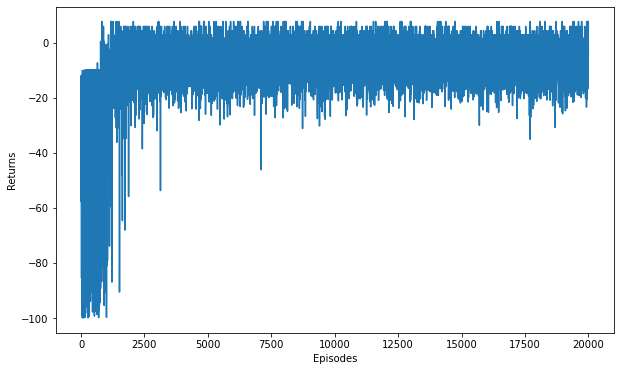

In [10]:
# Parameters
gamma = 0.9
epsilon = 0.1
alpha = 0.01
nb_episodes = 20000

# Create the environment
env = gym.make("Taxi-v3")

# Create the agent
agent = MonteCarloAgent(env, gamma, epsilon, alpha)

# Train the agent 
returns = agent.train(nb_episodes)

env.close()

plt.figure(figsize=(10, 6))
plt.plot(returns)
plt.xlabel("Episodes")
plt.ylabel("Returns")
plt.show()

As you may observe, the returns have a huge variance due to the exploration, what makes the plot quite ugly and unreadable. The following function allows to smooth the returns using a sliding average over the last $N$ epochs:

In [11]:
def running_average(x, N):
    cumsum = np.cumsum(np.insert(np.array(x), 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

**Q:** Plot the returns as well as their sliding average. Comment on the influence of exploration. 

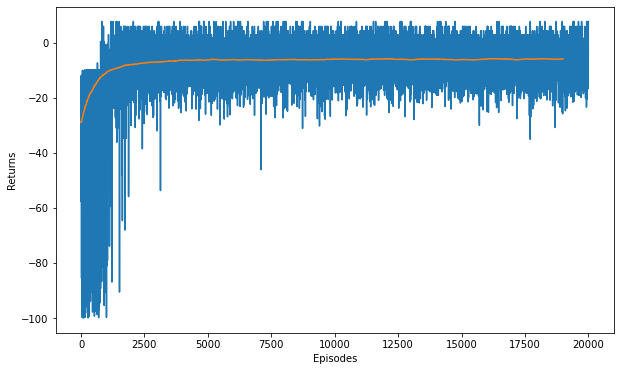

In [12]:
# Plot the returns
plt.figure(figsize=(10, 6))
plt.plot(returns)
plt.plot(running_average(returns, 1000))
plt.xlabel("Episodes")
plt.ylabel("Returns")
plt.show()

**Q:** Extend the agent with a `test(self, render)` method that performs a single episode on the environment without exploration, optionally renders each state but does **not** learn. You will have to re-train the agent, because the definition of its class has changed. Backup the previous value of `epsilon` in a temporary variable and reset it at the end of the episode. Have the method return the **undiscounted** sum of rewards in the episode, as well as the number of steps until termination.

After training (you can reduce the number of episodes), first observe a couple of test episodes with rendering on. Is the policy any good?

Perform 1000 test episodes without rendering and report the mean return over these 1000 episodes as the final performance of your agent.

In [13]:
class MonteCarloAgentTest (MonteCarloAgent):
    """
    Online Monte-Carlo agent with a test method.
    """

    def test(self, render=True):
        "Performs a test episode without exploration."
        previous_epsilon = self.epsilon
        self.epsilon = 0.0
        
        # Reset
        state = self.env.reset()
        done = False
        nb_steps = 0
        rewards= 0

        # Sample the episode
        while not done:
            if render:
                clear_output(wait=True)
                self.env.render()
                time.sleep(0.1)
            action = self.act(state)
            next_state, reward, done, info = self.env.step(action)
            rewards += reward
            state = next_state
            nb_steps += 1
            
        self.epsilon = previous_epsilon
            
        return rewards, nb_steps

Episode 19900 :
 return: -5.88217735810702
 steps: 16


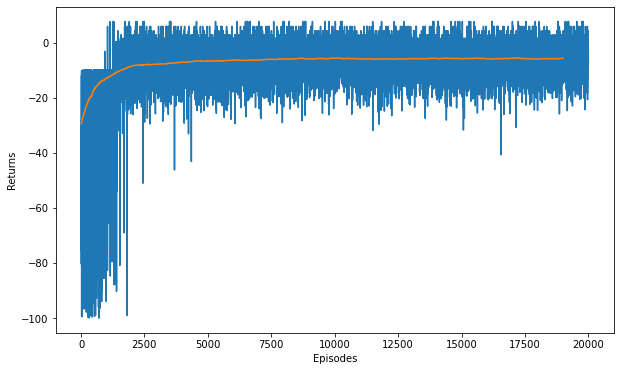

Test performance 6.325


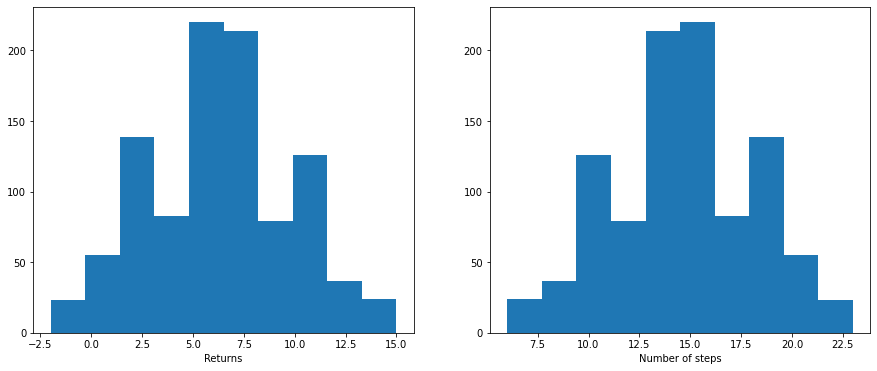

In [14]:
# Parameters
gamma = 0.9
epsilon = 0.1
alpha = 0.01
nb_episodes = 20000

# Create the environment
env = gym.make("Taxi-v3")

# Create the agent
agent = MonteCarloAgentTest(env, gamma, epsilon, alpha)

# Train the agent
returns = agent.train(nb_episodes)

# Plot training returns
plt.figure(figsize=(10, 6))
plt.plot(returns)
plt.plot(running_average(returns, 1000))
plt.xlabel("Episodes")
plt.ylabel("Returns")
plt.show()

# Test the agent for 1000 episodes
test_returns = []
test_steps = []
for episode in range(1000):
    return_episode, nb_steps = agent.test(render=False)
    test_returns.append(return_episode)
    test_steps.append(nb_steps)
print("Test performance", np.mean(test_returns))

plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.hist(test_returns)
plt.xlabel("Returns")
plt.subplot(122)
plt.hist(test_steps)
plt.xlabel("Number of steps")
plt.show()

In [15]:
# Visualize some episodes
returns = []
length_episode = []

for episode in range(5):
    
    # Perform one episode
    return_episode, nb_steps = agent.test(render=True)
    
    # Store info
    returns.append(return_episode)
    length_episode.append(nb_steps)


print("Returns:", returns)
print("Number of steps", length_episode)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
Returns: [1, 7, 3, 12, 3]
Number of steps [20, 14, 18, 9, 18]


**A:** the agent successfully delivers the client at the correct location. The path is not always the shortest one (especially in the vast area before G), but that is fine.

## Experiments

### Early stopping

**Q:** Train the agent for the smallest number of episodes where the returns seem to have stabilized (e.g. 2000 episodes). Test the agent. Does it work? Why?

Episode 1900 :
 return: -11.052893778075973
 steps: 200


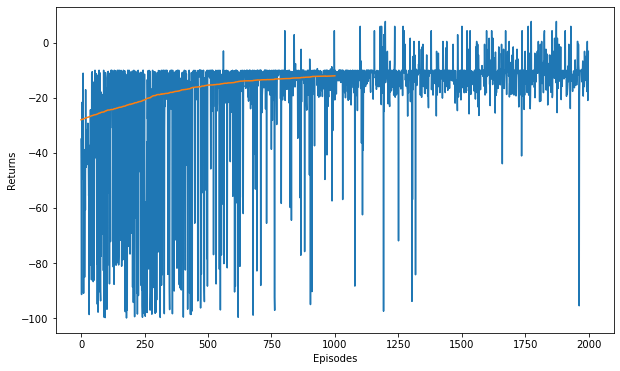

Test performance -147.357


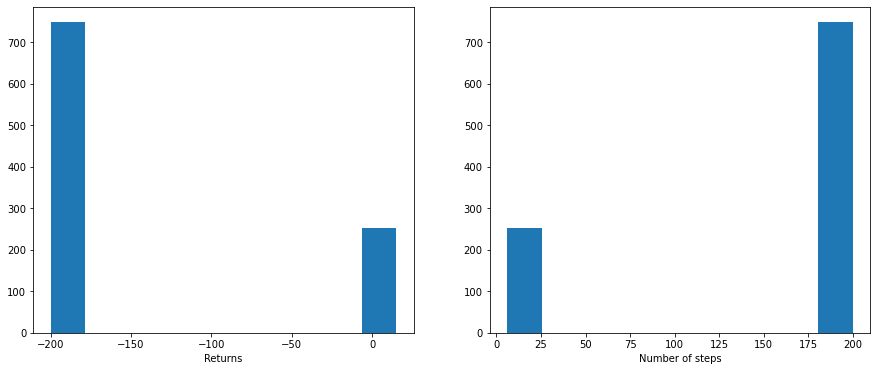

In [16]:
# Parameters
gamma = 0.9
epsilon = 0.1
alpha = 0.01
nb_episodes = 2000

# Create the environment
env = gym.make("Taxi-v3")

# Create the agent
agent = MonteCarloAgentTest(env, gamma, epsilon, alpha)

# Train the agent
returns = agent.train(nb_episodes)

# Plot training returns
plt.figure(figsize=(10, 6))
plt.plot(returns)
plt.plot(running_average(returns, 1000))
plt.xlabel("Episodes")
plt.ylabel("Returns")
plt.show()

# Test the agent for 1000 episodes
test_returns = []
test_steps = []
for episode in range(1000):
    return_episode, nb_steps = agent.test(render=False)
    test_returns.append(return_episode)
    test_steps.append(nb_steps)
print("Test performance", np.mean(test_returns))

plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.hist(test_returns)
plt.xlabel("Returns")
plt.subplot(122)
plt.hist(test_steps)
plt.xlabel("Number of steps")
plt.show()

**A:** Although the returns are already between -20 and +10, as after 50000 episodes, the greedy policy is not optimal as some states still have a very bad policy (the agent sometimes goes back and forth between two states) or just a bad one (not optimal path). The negative returns at the end of learning are due to the exploration: the agent performs illegal pickups or dropoffs. Early in learning, this is due to bad estimates of the Q-values. The return of an episode is a bad estimate of the performance: it report both the exploration and the exploitation. Unfortunately, it is the only one we have...  

### Discount rate

**Q:** Change the value of the discount factor $\gamma$. As the task is episodic (maximum 200 steps), try a discount rate of 1. What happens? Conclude.

Episode 19900 :
 return: -13.0
 steps: 25


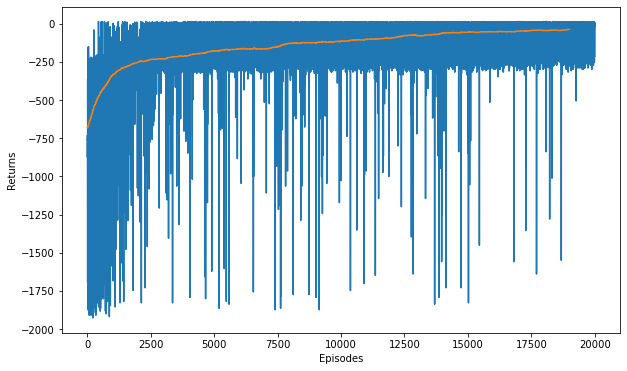

Test performance -64.025


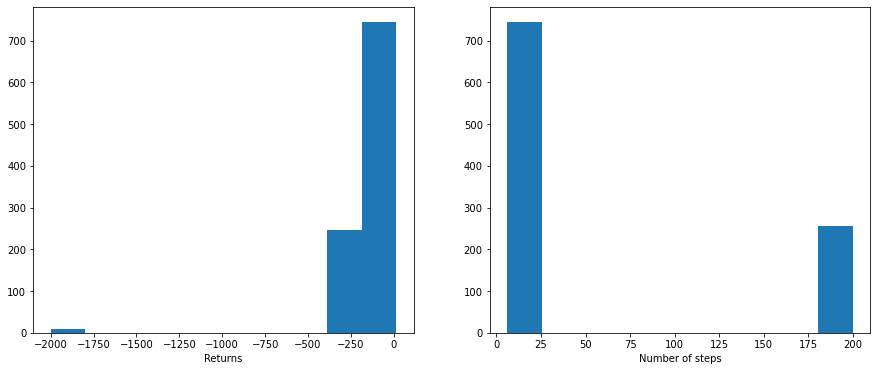

In [17]:
# Parameters
gamma = 1.0
epsilon = 0.1
alpha = 0.01
nb_episodes = 20000

# Create the environment
env = gym.make("Taxi-v3")

# Create the agent
agent = MonteCarloAgentTest(env, gamma, epsilon, alpha)

# Train the agent
returns = agent.train(nb_episodes)

# Plot training returns
plt.figure(figsize=(10, 6))
plt.plot(returns)
plt.plot(running_average(returns, 1000))
plt.xlabel("Episodes")
plt.ylabel("Returns")
plt.show()

# Test the agent for 1000 episodes
test_returns = []
test_steps = []
for episode in range(1000):
    return_episode, nb_steps = agent.test(render=False)
    test_returns.append(return_episode)
    test_steps.append(nb_steps)
print("Test performance", np.mean(test_returns))

plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.hist(test_returns)
plt.xlabel("Returns")
plt.subplot(122)
plt.hist(test_steps)
plt.xlabel("Number of steps")
plt.show()

**A:** Rather tricky question... With a discount factor of 1, the agent does not converge as fast as with gamma = 0.9. This is due to the **variance** of the returns: imagine your episode is optimal all along, but at the last moment, the agent performs an illegal dropoff action. The undiscounted return of the episode will be negative and **all** actions taken during the episode will be punished, although only the last one is responsible for the bad return.

Using a discount factor < 1 allows the first actions to stop caring about the final rewards, as they are discounted by $\gamma^T$, which is very small. Take-home message: even if your task is episodic, use $\gamma < 1$.

### Learning rate

**Q:** Vary the learning rate `alpha`. What happens?

Episode 19900 :
 return: -3.8232660371605287
 steps: 16


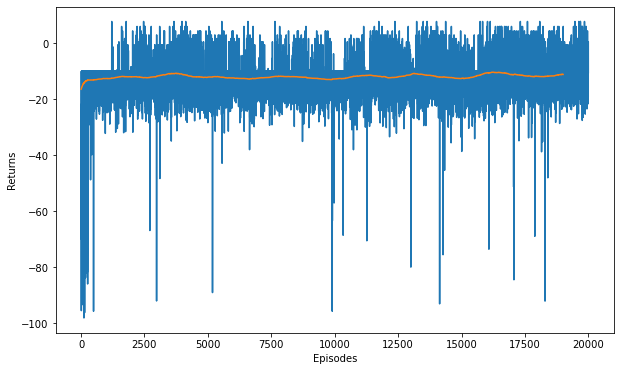

Test performance -148.272


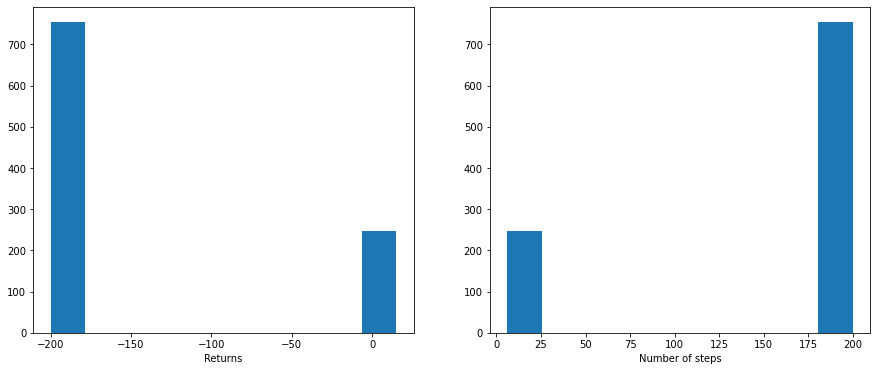

In [18]:
# Parameters
gamma = 0.9
epsilon = 0.1
alpha = 0.5
nb_episodes = 20000

# Create the environment
env = gym.make("Taxi-v3")

# Create the agent
agent = MonteCarloAgentTest(env, gamma, epsilon, alpha)

# Train the agent
returns = agent.train(nb_episodes)

# Plot training returns
plt.figure(figsize=(10, 6))
plt.plot(returns)
plt.plot(running_average(returns, 1000))
plt.xlabel("Episodes")
plt.ylabel("Returns")
plt.show()

# Test the agent for 1000 episodes
test_returns = []
test_steps = []
for episode in range(1000):
    return_episode, nb_steps = agent.test(render=False)
    test_returns.append(return_episode)
    test_steps.append(nb_steps)
print("Test performance", np.mean(test_returns))

plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.hist(test_returns)
plt.xlabel("Returns")
plt.subplot(122)
plt.hist(test_steps)
plt.xlabel("Number of steps")
plt.show()

**A:** if the learning rate is too high (0.5), the network does not converge and becomes unstable, as updates "erases" very quickly the previous values, what is bad given the high variance of the returns. If the learning rate is too low, learning takes forever. Classical machine learning problem... 0.01 works actually quite well.

### Exploration parameter

**Q:** Vary the exploration parameter `epsilon` and observe its impact on learning.

Episode 19900 :
 return: -0.5856821172999982
 steps: 12


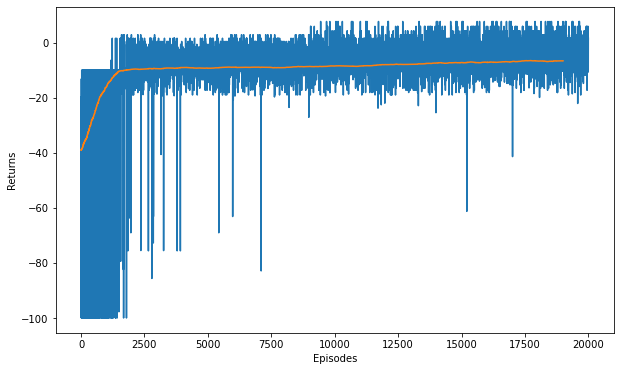

Test performance -107.576


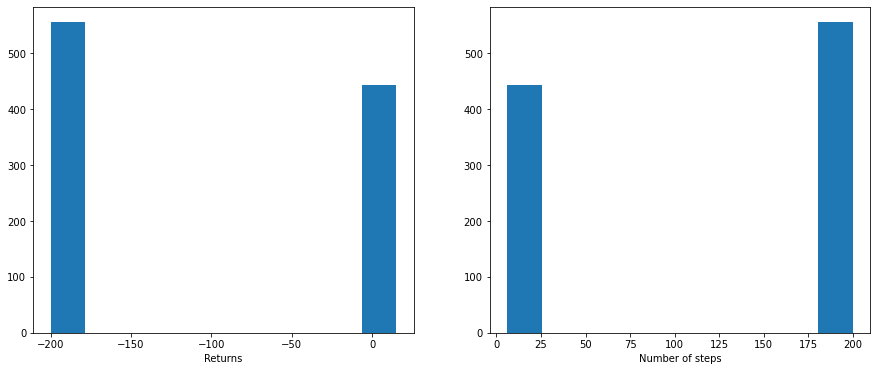

In [19]:
# Parameters
gamma = 0.9
epsilon = 0.01 # or 0.3, etc.
alpha = 0.01
nb_episodes = 20000

# Create the environment
env = gym.make("Taxi-v3")

# Create the agent
agent = MonteCarloAgentTest(env, gamma, epsilon, alpha)

# Train the agent
returns = agent.train(nb_episodes)

# Plot training returns
plt.figure(figsize=(10, 6))
plt.plot(returns)
plt.plot(running_average(returns, 1000))
plt.xlabel("Episodes")
plt.ylabel("Returns")
plt.show()

# Test the agent for 1000 episodes
test_returns = []
test_steps = []
for episode in range(1000):
    return_episode, nb_steps = agent.test(render=False)
    test_returns.append(return_episode)
    test_steps.append(nb_steps)
print("Test performance", np.mean(test_returns))

plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.hist(test_returns)
plt.xlabel("Returns")
plt.subplot(122)
plt.hist(test_steps)
plt.xlabel("Number of steps")
plt.show()

**A:** The exploration should be at least 0.1 in order to find the optimal policy. 0.2 or 0.3 find a good policy faster, but explore too much at the end of learning.

### Exploration scheduling

Even with a good learning rate (0.01) and a discount factor of 0.9, the exploration parameter as a huge impact on the performance: too low and the agent does not find the optimal policy, too high and the agent is inefficient at the end of learning. 

**Q:** Implement scheduling for epsilon. You can use exponential scheduling as in the bandits exercise:

$$\epsilon = \epsilon \times (1 - \epsilon_\text{decay})$$

at the end of each episode, with $\epsilon_\text{decay}$ being a small decay parameter (`1e-5` or so).

Find a correct value for $\epsilon_\text{decay}$. Do not hesitate to fine-tune alpha at the same time.

*Tip:* Prepare and visualize the scheduling in a different cell, and use the initial value of $\epsilon$ and $\epsilon_\text{decay}$ that seem to make sense. 

In [20]:
class DecayMonteCarloAgent (MonteCarloAgentTest):
    """
    Monte-Carlo agent with decay of the exploration parameter.
    """
    
    def __init__(self, env, gamma, epsilon, decay_epsilon, alpha):
        """
        :param env: gym-like environment
        :param gamma: discount factor
        :param epsilon: exploration parameter
        :param decay_epsilon: exploration decay parameter
        :param alpha: learning rate
        """
        self.decay_epsilon = decay_epsilon
        
        super().__init__(env, gamma, epsilon, alpha)
    
    
    def train(self, nb_episodes, render=False):
        "Runs the agent on the environment for nb_episodes. Returns the list of obtained returns."

        # Returns
        returns = []

        # Fixed number of episodes
        for episode in range(nb_episodes):

            # Reset
            state = self.env.reset()
            done = False
            nb_steps = 0

            # Store transitions
            transitions = []

            # Sample the episode
            while not done:
                
                # Render the current state
                if render:
                    clear_output(wait=True)
                    self.env.render()
                    time.sleep(0.1)

                # Select an action 
                action = self.act(state)

                # Perform the action
                next_state, reward, done, info = self.env.step(action)

                # Store the transition
                transitions.append([state, action, reward])

                # Go in the next state
                state = next_state

                # Increment time
                nb_steps += 1

            # Update the Monte Carlo agent after the episode is completed
            return_episode = self.update(transitions)   
            
            # Decay epsilon
            self.epsilon = self.epsilon * (1 - self.decay_epsilon)

            # Store info
            returns.append(return_episode)
            
            # Print info
            if episode % 100 == 0:
                clear_output(wait=True)
                print('Episode', episode, ':')
                print(' return:', return_episode)
                print(' steps:', nb_steps)
                print(' epsilon:', self.epsilon)
            
            
        return returns

Episode 19900 :
 return: -10.148872536022827
 steps: 25
 epsilon: 0.054667262335293364


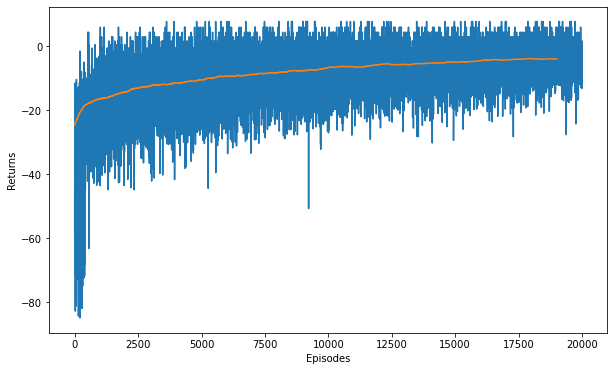

Test performance 6.8


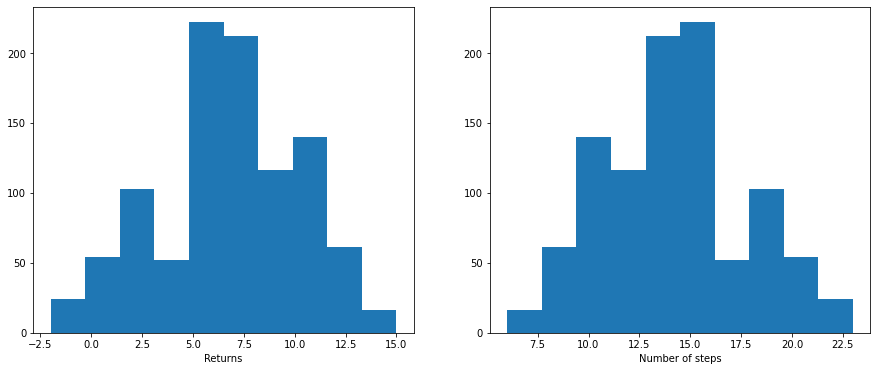

In [33]:
# Parameters
gamma = 0.9
epsilon = 0.4
decay_epsilon = 1e-4
alpha = 0.05
nb_episodes = 20000

# Create the environment
env = gym.make("Taxi-v3")

# Create the agent
agent = DecayMonteCarloAgent(env, gamma, epsilon, decay_epsilon, alpha)

# Train the agent
returns = agent.train(nb_episodes)

# Plot training returns
plt.figure(figsize=(10, 6))
plt.plot(returns)
plt.plot(running_average(returns, 1000))
plt.xlabel("Episodes")
plt.ylabel("Returns")
plt.show()

# Test the agent for 1000 episodes
test_returns = []
test_steps = []
for episode in range(1000):
    return_episode, nb_steps = agent.test(render=False)
    test_returns.append(return_episode)
    test_steps.append(nb_steps)
print("Test performance", np.mean(test_returns))

plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.hist(test_returns)
plt.xlabel("Returns")
plt.subplot(122)
plt.hist(test_steps)
plt.xlabel("Number of steps")
plt.show()

In [34]:
# Visualize some episodes
returns = []
length_episode = []

for episode in range(5):
    
    # Perform one episode
    return_episode, nb_steps = agent.test(render=True)
    
    # Store info
    returns.append(return_episode)
    length_episode.append(nb_steps)


print("Returns:", returns)
print("Number of steps", length_episode)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
Returns: [5, 4, 6, 1, 2]
Number of steps [16, 17, 15, 20, 19]


**A:** As seen with bandits, decaying the exploration parameter with the right schedule improves very significantly the speed of learning and the optimality.